<a href="https://colab.research.google.com/github/sunidhijoshi281/Fraud_Detection_Model_For_Banks/blob/main/Copy_of_Cass_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [29]:
train_data= pd.read_csv('/content/user_data_training.csv')
ph= pd.read_csv('/content/payment_history_data.csv')

ph.max_bal = np.where(ph.max_bal.isnull(), ph.curr_remaining, ph.max_bal)


In [30]:

sort_ph = ph.sort_values(by = ["id"])
sort_ph.drop('last_update',axis = 'columns',inplace = True)
sort_ph.drop('p_code',axis = 'columns',inplace = True)
sort_ph.drop('recent_payment_activity',axis = 'columns',inplace = True)

phf = sort_ph.groupby(sort_ph['id']).mean()


In [31]:
df = pd.merge(phf,train_data,on = 'id')

In [32]:
df.p_limit.fillna(value = df.p_limit.mean(),inplace = True)
df.Beta.fillna(value = df.Beta.mean(),inplace = True)

In [33]:
df2= df.drop(['id'],axis='columns')


Random over-sampling:
1    600
0    600
Name: label, dtype: int64


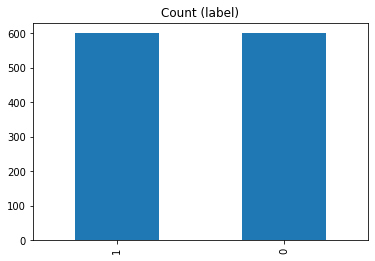

In [34]:

count_class_0, count_class_1 = df2.label.value_counts()

# Divide by class
df2_class_0 = df2[df2['label'] == 0]
df2_class_1 = df2[df2['label'] == 1]
df2_class_1_over = df2_class_1.sample(count_class_0, replace=True)
df2 = pd.concat([df2_class_0, df2_class_1_over], axis=0)

print('Random over-sampling:')
print(df2.label.value_counts())

df2.label.value_counts().plot(kind='bar', title='Count (label)');


In [35]:
def detect_outliers(df2,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(f2[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df2[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df2[(df2[col] < Q1 - outlier_step) | (df2[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

    # detect outliers from Features
    Outliers_to_drop = detect_outliers(train,2,Features)
    # Drop outliers
    train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [36]:
Features= (['Late_2', 'Late_1', 'days_late_Sum', 'Eta',
       'p_limit', 'curr_remaining', 'max_bal', 'Alpha', 'Beta','normal_payment',
        'Delta', 'Zeta', 'Theta', 'Iota', 'Kappa','Late_3','Epsilon','Gamma',
       'Lambda', 'omikron'])
y_train=df2.label
x_train= df2[Features]


In [37]:
test_data=pd.read_csv('/content/user_data_testing.csv')
df_test = pd.merge(phf,test_data,on = 'id')

df_test.p_limit.fillna(value = df_test.p_limit.mean(),inplace = True)
df_test.Beta.fillna(value = df_test.Beta.mean(),inplace = True)

id_test = df_test.id
df_test = df_test.drop('id',axis = 'columns')
df_test=df_test[Features]

In [38]:
from sklearn.ensemble import RandomForestClassifier
model1 = RandomForestClassifier(n_estimators=800,min_samples_split=2,max_depth=10)
model1.fit(x_train,y_train)
y_pred=model1.predict(df_test)
model1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

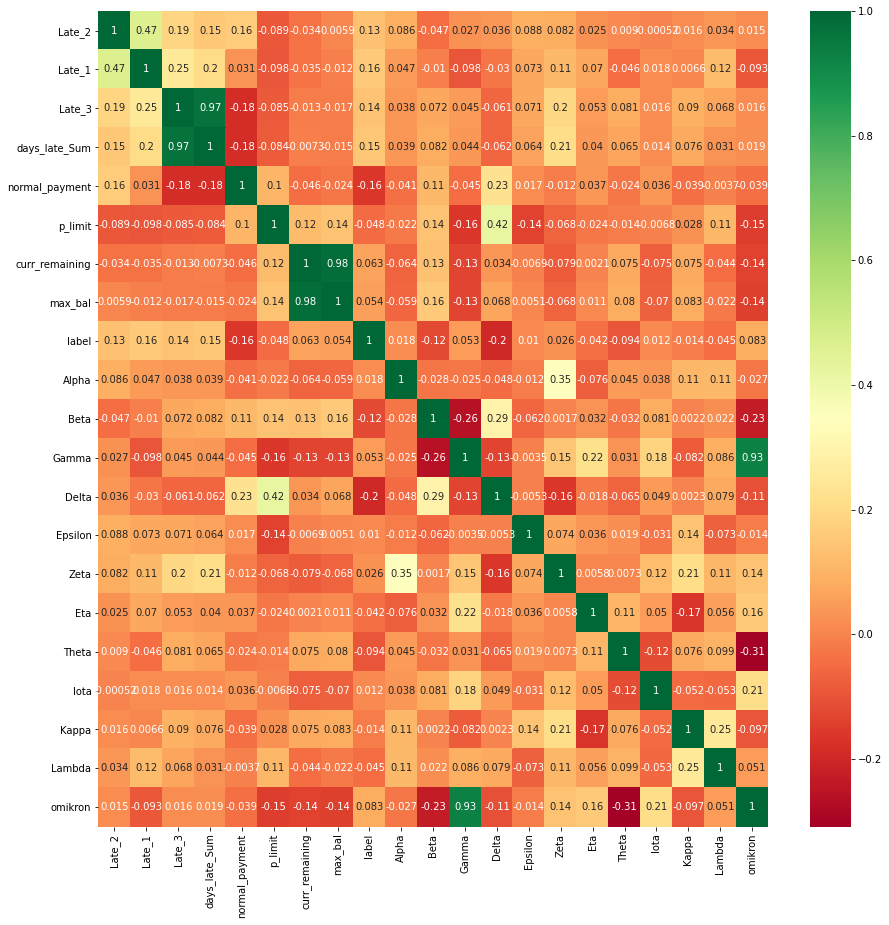

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
#get correlations of each features in dataset
corrmat = df2.corr()
top_corr_features = corrmat.index
pyplot.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [40]:
submission = pd.DataFrame({'label':y_pred,'id':id_test})
submission.shape
submission.to_csv('cass_final.csv',index=False)
print("Saved the submission file")

Saved the submission file
